## 1, ライブラリをインポート

In [28]:
import os, io, re
import glob
import pickle
import shap
import optuna
import lightgbm as lgb
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'family' : 'meiryo'}
plt.rc('font', **font)

In [29]:
from PIL import Image
from functools import partial

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import keras.backend as K
from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense

In [30]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6975173676493969515,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4937233203
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7853076390348658531
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

## 2, 学習データを前処理

In [31]:
for i,file in enumerate(os.listdir("./csv/")):
    if i == 0:
        df = pd.read_csv("./csv/" + file, encoding="SJIS")
    else:
        df = pd.concat([df,pd.read_csv("./csv/" +file, encoding="SJIS")])
        
df.columns = ["image","front","close","background","focus","cute","position","brightness","plural","care"]
df = df.reset_index(drop=True)
df["image"] = [("00000" + i) for i in df["image"]]
df

,image,front,close,background,focus,cute,position,brightness,plural,care
0,00000025_018.jpg,5,5,5,4,2,4,2,0,0
1,00000025_022.jpg,5,4,3,4,3,4,2,0,0
2,00000025_029.jpg,3,3,3,5,4,3,2,0,1
3,00000026_001.jpg,5,3,2,4,4,3,3,0,1
4,00000026_008.jpg,5,3,4,5,3,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...
595,00000011_025.jpg,4,3,4,5,4,3,3,2,0
596,00000011_027.jpg,5,4,2,4,4,3,3,0,0
597,00000012_010.jpg,5,3,5,5,5,3,3,0,1
598,00000012_022.jpg,3,3,4,3,3,4,3,0,0


Data must have variance to compute a kernel density estimate.


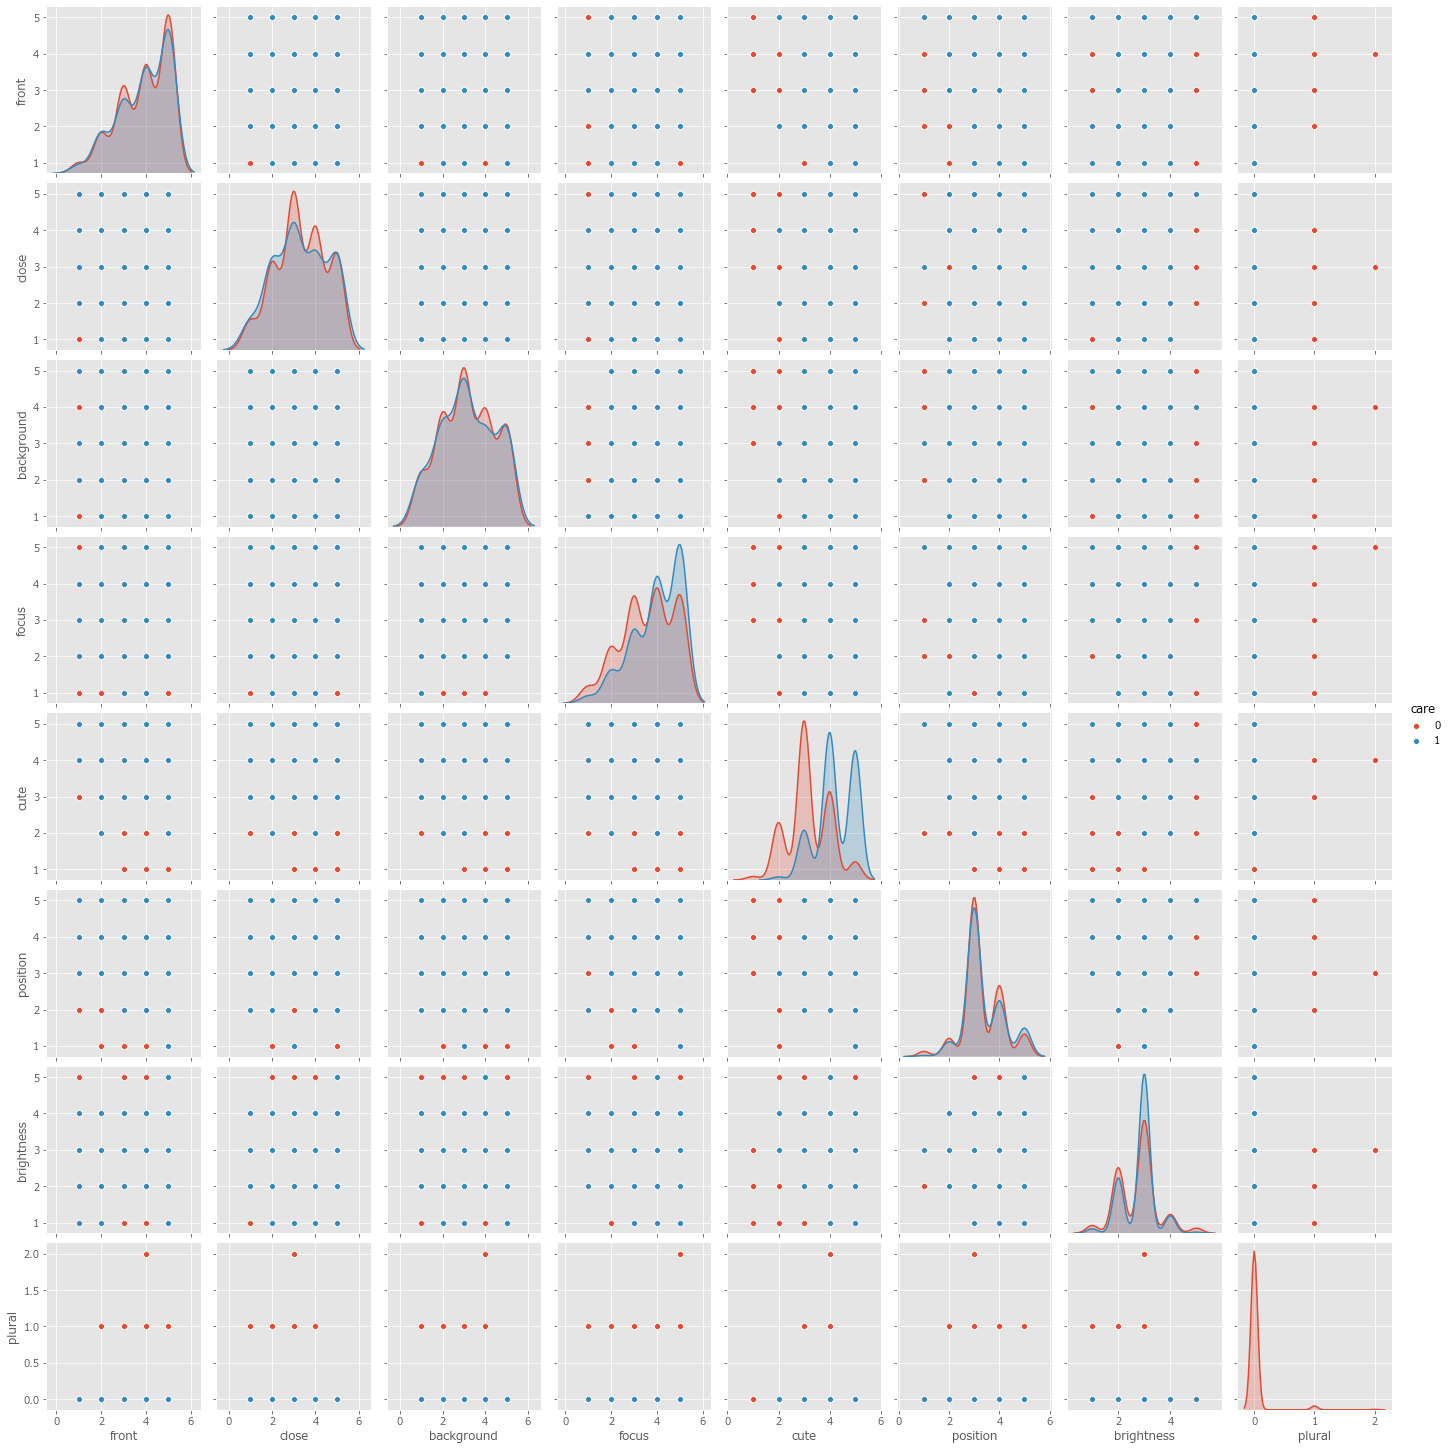

In [35]:
#離散なのに散布図です・・・欲しいのは対角線に表示されている確率密度です。
g = sns.pairplot(df.drop("image",axis=1),hue="care")
g.fig.set_figheight(20)
g.fig.set_figwidth(20)

In [18]:
image_size=60
X=[]
Y=[]

for image_path in df["image"]:
    
    #画像ファイル取得
    img_file = glob.glob("./image/" + image_path)
    if not img_file:
        print(image_path)
        continue
    image = Image.open(img_file[0])
    image = image.convert("RGB")
    # リサイズ
    image = image.resize((image_size, image_size))
    X.append(np.asarray(image))
    
    #水増し(一旦保留)
    #row,col,ch= np.asarray(image).shape
    #mean = 0
    #sigma = 10
    #gauss = np.random.normal(mean,sigma,(row,col,ch))
    #gauss = gauss.reshape(row,col,ch)
    #gauss_img = image + gauss
    
    #X.append(np.asarray(gauss_img, dtype=np.uint8))
    
del image

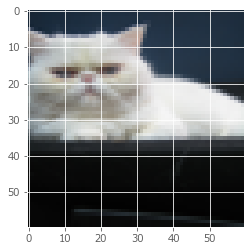

In [19]:
#解像度を確認
plt.imshow(X[0])
plt.show()

## 3, 小モデル作成

In [20]:
def column_predict(X,Y,column):
    
    sess = tf.InteractiveSession()
    
    X = X.astype("float32") / 255
    X_train, X_valid, y_train, y_valid = train_test_split(X,Y,random_state = 0,test_size = 0.1)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(image_size,image_size,3)))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")

    hist = model.fit(X_train, y_train, epochs=150, batch_size=20,verbose=0)
    pickle.dump(model,open("model/model_" + str(column) + ".sav","wb"))
    
    plt.figure(figsize=(8, 4))
    plt.plot(hist.history["loss"])
    plt.title("Loss(" + column + ")")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc="upper left")
    plt.show()

    pred = model.predict(X_valid)
    MSE_pred = mean_squared_error(pred, y_valid)
    print(MSE_pred)

    mean_pred = np.full(len(y_valid), y_train.mean())
    MSE_mean = mean_squared_error(mean_pred, y_valid)
    print(MSE_mean)

    plt.figure(figsize=(8, 4))
    plt.title(column)
    plt.plot(y_valid, label="Actual")
    plt.plot(pred, c="b", label="pred", alpha=0.6)
    plt.legend(loc="upper right")
    plt.show()

    
    with tf.Session() as sess:
         sess.run(tf.global_variables_initializer())    

    explainer = shap.DeepExplainer(model, (X*255))
    shap_values = explainer.shap_values(X[[0]]*255)
    shap.image_plot(shap_values, X[[0]])
    plt.gcf().set_size_inches(20, 20)
    
    return(MSE_pred,MSE_mean)
    

front


An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


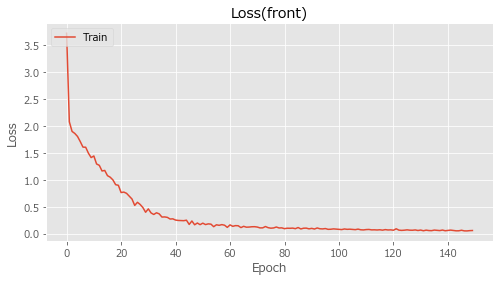

1.80346264551715
1.203840877914952


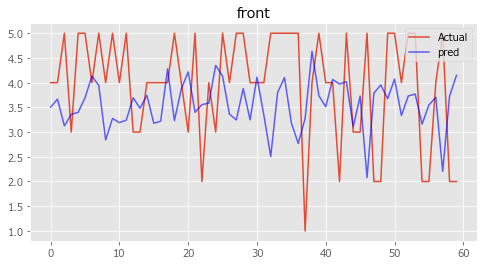

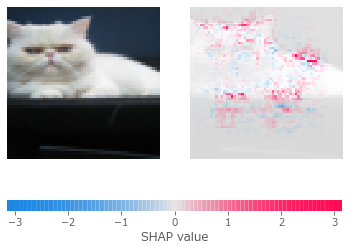

close


An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


<Figure size 1440x1440 with 0 Axes>

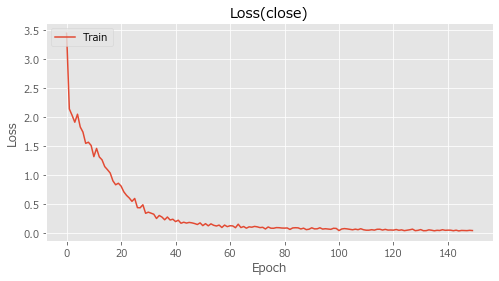

1.3645470606137655
1.2102194787379974


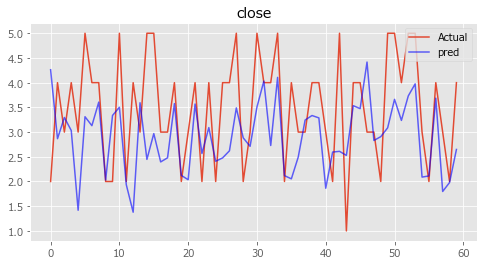

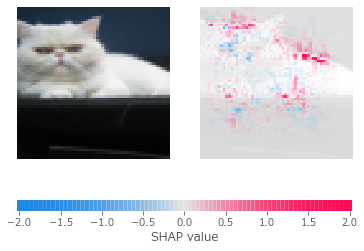

background


An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


<Figure size 1440x1440 with 0 Axes>

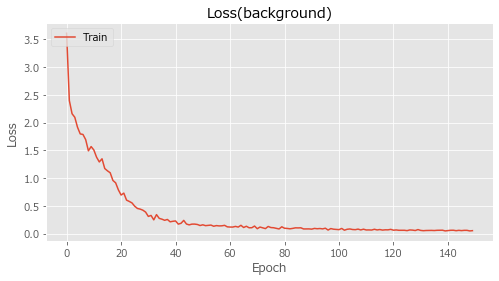

1.4604287082537282
1.5901783264746228


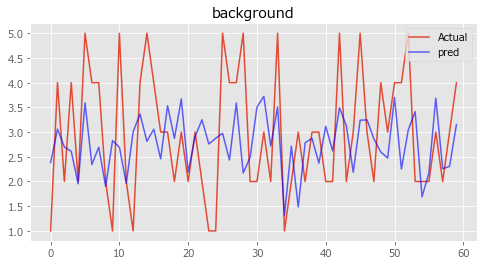

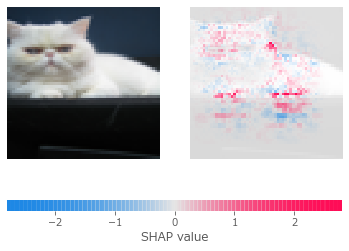

focus


An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


<Figure size 1440x1440 with 0 Axes>

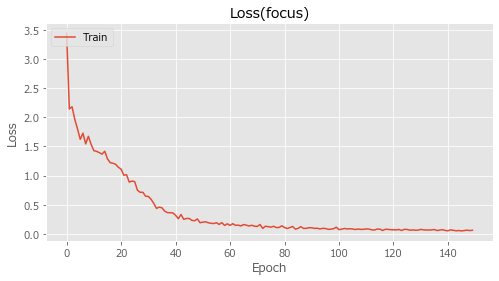

1.8725862839890595
1.3460219478737996


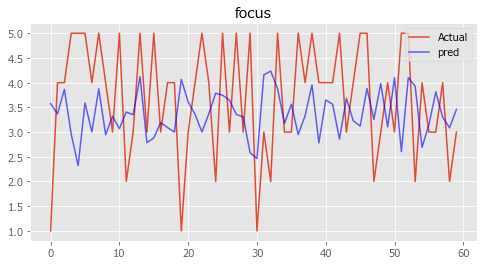

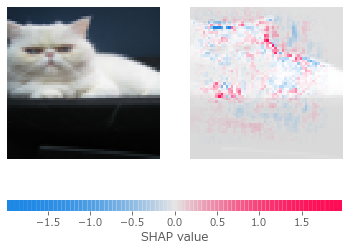

cute


An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


<Figure size 1440x1440 with 0 Axes>

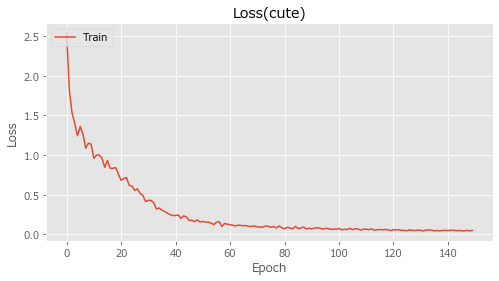

1.329330436837723
1.0065672153635117


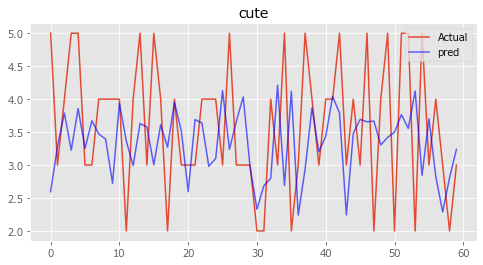

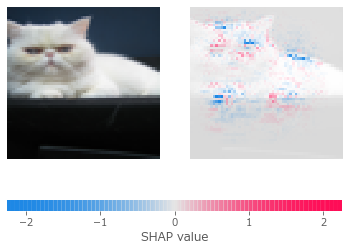

position


An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


<Figure size 1440x1440 with 0 Axes>

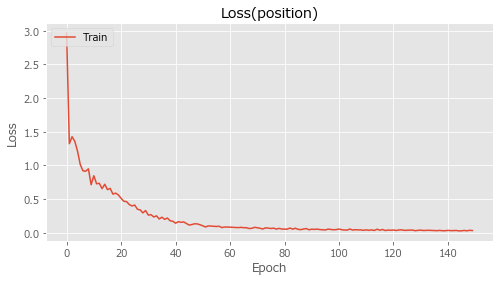

0.8301359597558076
0.7051989026063102


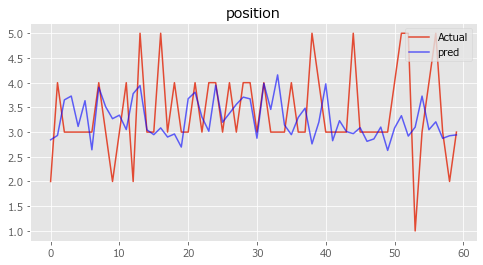

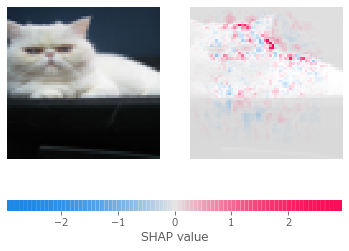

brightness


An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


<Figure size 1440x1440 with 0 Axes>

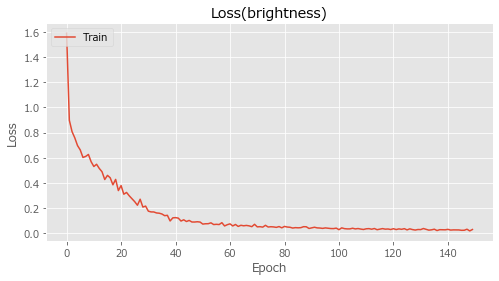

0.6067641693521088
0.5308641975308641


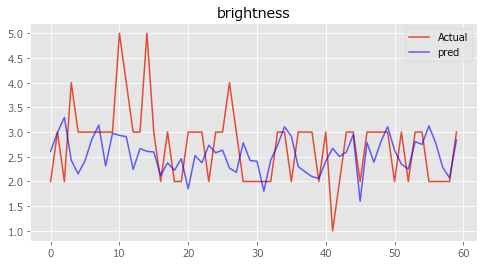

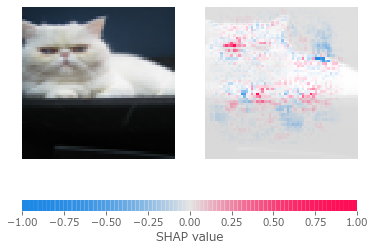

plural


An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


<Figure size 1440x1440 with 0 Axes>

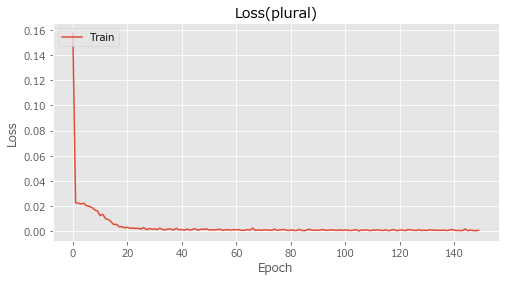

0.016320907027274907
0.016392318244170097


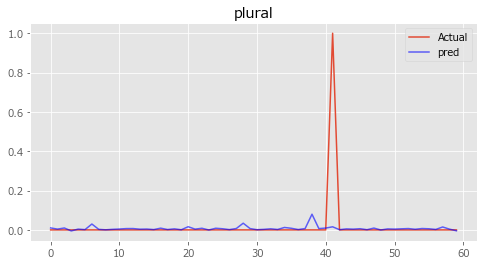

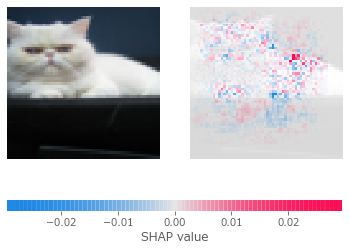

<Figure size 1440x1440 with 0 Axes>

In [21]:
predict_df = pd.DataFrame(index=["MSE_pred","MSE_mean"])

X = np.array(X)

for column in ["front","close","background","focus","cute","position","brightness","plural"]:
    print("============================================================")
    print(column)
    Y = np.array(df[column])
    predict_df[column] = column_predict(X,Y,column)

## 4, 大モデル作成

In [22]:
X2 = df[["front","close","background","focus","cute","position","brightness","plural"]]
Y2 = df["care"].values

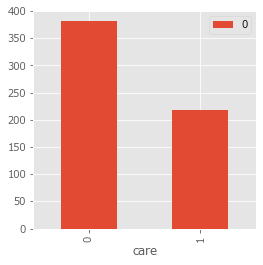

In [23]:
#偏りはsample_weightで調整する予定
pd.DataFrame(df.groupby("care").size()).plot(kind = "bar", figsize = (4, 4))
plt.show()

In [24]:
#最適化される関数
def objective(x,y,trial):
    params={
        "num_leaves":trial.suggest_int("num_leaves",30,300),
        "learning_rate":trial.suggest_uniform("learning_rate",0.1,2.0),
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.1,1.0),
        "max_depth":trial.suggest_int("max_depth",3,10),
        "objective":trial.suggest_categorical("objective",["binary"]),
        "random_state":trial.suggest_int("random_state",0,0)
    }
    
    score = 0
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
    for train_index,test_index in kf.split(x,y):
        X_train = x.iloc[train_index]
        X_test = x.iloc[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train,y_train)
        pred = model.predict(X_test)
        score += accuracy_score(y_test,pred)
    return score    

In [37]:
def last_predict(X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = 0,test_size = 0.1)

    evals_result = {}
    study = optuna.create_study(direction="maximize",sampler=optuna.samplers.RandomSampler(seed=0))
    study.optimize(partial(objective,X_train,y_train),n_trials=30)
    model = lgb.LGBMClassifier(**study.best_params)
    model.fit(X_train, y_train,callbacks=[lgb.record_evaluation(evals_result)])
    pickle.dump(model,open("model/model_lgb.sav","wb"))
    
    #lgbのlossをグラフに出す予定
    #train_metric = evals_result['validation_0']['loss']
    #plt.plot(train_metric, label='train loss')
    #plt.grid()
    #plt.legend()
    #plt.xlabel('rounds')
    #plt.ylabel('logloss')
    #plt.show()
    
    pred = model.predict(X_test)
    acc = accuracy_score(pred, y_test)
    print("acc:" + str(acc))
    
    #混合行列など出す予定
    plt.figure(figsize=(8, 4))
    plt.plot(y_test, label="Actual")
    plt.plot(pred, c="b", label="pred", alpha=0.6)
    plt.legend(loc="upper right")
    plt.show()
    
    Xcolumns = X.columns
    features = Xcolumns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    #今はimportanceだが、いずれshapに変える予定
    plt.figure(figsize=(8,4))
    plt.title("importance")
    plt.barh(range(len(indices)),importances[indices],align="center")
    plt.yticks(range(len(indices)),features[indices])
    plt.show()
    
    explainer = shap.TreeExplainer(model,X)
    shap_values = explainer.shap_values(X.loc[[0]])
    shap.force_plot(explainer.expected_value, 
                shap_values, 
                X.loc[[0]], 
                matplotlib=True,
                )

[I 2020-04-14 14:55:16,285] Finished trial#0 with value: 3.398148148148148 with parameters: {'num_leaves': 202, 'learning_rate': 1.2264047746275348, 'feature_fraction': 0.8598391737229156, 'max_depth': 6, 'objective': 'binary', 'random_state': 0}. Best is trial#0 with value: 3.398148148148148.
[I 2020-04-14 14:55:16,557] Finished trial#1 with value: 3.175925925925926 with parameters: {'num_leaves': 225, 'learning_rate': 1.7097783036898382, 'feature_fraction': 0.6612073271073751, 'max_depth': 5, 'objective': 'binary', 'random_state': 0}. Best is trial#0 with value: 3.398148148148148.
[I 2020-04-14 14:55:16,815] Finished trial#2 with value: 3.296296296296296 with parameters: {'num_leaves': 117, 'learning_rate': 1.7943687014859515, 'feature_fraction': 0.9672964844509263, 'max_depth': 5, 'objective': 'binary', 'random_state': 0}. Best is trial#0 with value: 3.398148148148148.
[I 2020-04-14 14:55:17,041] Finished trial#3 with value: 3.4814814814814814 with parameters: {'num_leaves': 223, 'l

[I 2020-04-14 14:55:23,233] Finished trial#27 with value: 2.981481481481481 with parameters: {'num_leaves': 41, 'learning_rate': 1.7004499513686888, 'feature_fraction': 0.6824567261687999, 'max_depth': 9, 'objective': 'binary', 'random_state': 0}. Best is trial#16 with value: 3.6574074074074074.
[I 2020-04-14 14:55:23,511] Finished trial#28 with value: 3.4537037037037037 with parameters: {'num_leaves': 158, 'learning_rate': 0.6029873121385543, 'feature_fraction': 0.45803867748276617, 'max_depth': 6, 'objective': 'binary', 'random_state': 0}. Best is trial#16 with value: 3.6574074074074074.
[I 2020-04-14 14:55:23,757] Finished trial#29 with value: 3.62037037037037 with parameters: {'num_leaves': 214, 'learning_rate': 0.4133868744595799, 'feature_fraction': 0.4328272834735061, 'max_depth': 3, 'objective': 'binary', 'random_state': 0}. Best is trial#16 with value: 3.6574074074074074.


acc:0.75


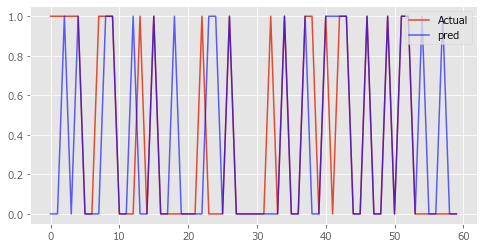

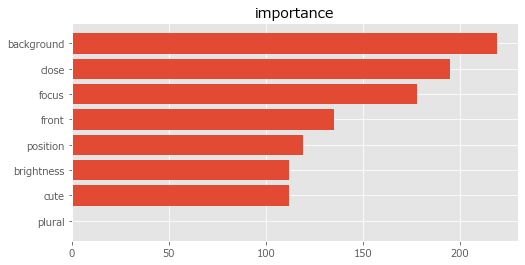

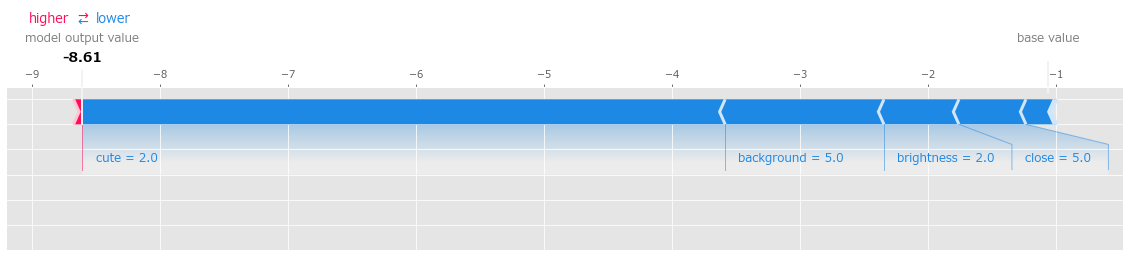

In [38]:
last_predict(X2,Y2)

## 以下考察中

In [120]:
sess = tf.InteractiveSession()

predict_df = pd.DataFrame(index=["MSE_pred","MSE_mean"])

X = np.array(X)

#["front","close","background","focus","cute","position","brightness","plural"]
column = "front"
Y = np.array(df[column])

X = X.astype('float32') / 255
X_train, X_valid, y_train, y_valid = train_test_split(X,Y,random_state = 0,test_size = 0.2)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size,image_size,3)))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')

hist = model.fit(X_train, y_train, epochs=150, batch_size=20,verbose=1)

Epoch 1/150
480/480 [==============================] - 1s 1ms/step - loss: 3.4678
Epoch 2/150
480/480 [==============================] - 0s 512us/step - loss: 1.4658
Epoch 3/150
480/480 [==============================] - 0s 486us/step - loss: 1.5380
Epoch 4/150
480/480 [==============================] - 0s 486us/step - loss: 1.4372
Epoch 5/150
480/480 [==============================] - 0s 476us/step - loss: 1.4547
Epoch 6/150
480/480 [==============================] - 0s 464us/step - loss: 1.4761
Epoch 7/150
480/480 [==============================] - 0s 479us/step - loss: 1.4452
Epoch 8/150
480/480 [==============================] - 0s 476us/step - loss: 1.4124
Epoch 9/150
480/480 [==============================] - 0s 483us/step - loss: 1.4574
Epoch 10/150
480/480 [==============================] - 0s 492us/step - loss: 1.3618
Epoch 11/150
480/480 [==============================] - 0s 509us/step - loss: 1.5212
Epoch 12/150
480/480 [==============================] - 0s 486us/step - loss

In [109]:
with tf.Session() as sess:
     sess.run(tf.global_variables_initializer())  

In [110]:
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [x.copy()]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

[<tf.Tensor 'conv2d_34_input:0' shape=(?, 60, 60, 3) dtype=float32>]

In [121]:
#高速版(未完成)
layer = 8

feed_dict = dict(zip([model.layers[0].input], [X.copy() * 255]))

In [122]:
feed_dict

{<tf.Tensor 'conv2d_38_input:0' shape=(?, 60, 60, 3) dtype=float32>: array([[[[0.09019608, 0.14117648, 0.20392157],
          [0.09411765, 0.14509805, 0.20392157],
          [0.09411765, 0.14901961, 0.20784314],
          ...,
          [0.10980392, 0.17254902, 0.23529412],
          [0.10980392, 0.17254902, 0.23137255],
          [0.10588235, 0.16862746, 0.22745098]],
 
         [[0.09411765, 0.14509805, 0.20392157],
          [0.09411765, 0.14509805, 0.20784314],
          [0.09411765, 0.14901961, 0.20784314],
          ...,
          [0.11372549, 0.1764706 , 0.23529412],
          [0.10980392, 0.17254902, 0.23529412],
          [0.10980392, 0.16862746, 0.23137255]],
 
         [[0.09803922, 0.15294118, 0.21176471],
          [0.09803922, 0.14901961, 0.21176471],
          [0.09411765, 0.14901961, 0.21176471],
          ...,
          [0.11372549, 0.1764706 , 0.23529412],
          [0.11372549, 0.17254902, 0.23529412],
          [0.10980392, 0.16862746, 0.23137255]],
 
         ...,


In [123]:
temp = K.get_session().run(model.layers[layer].input, feed_dict)

In [124]:
e = shap.DeepExplainer(
    (model.layers[layer].input, model.layers[-1].output),
    temp,
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


keras is no longer supported, please use tf.keras instead.


AttributeError: 'list' object has no attribute 'shape'

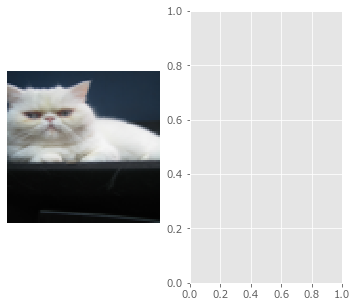

In [12]:
shap_values = e.shap_values(map2layer(X[[0]], 8), ranked_outputs=1)

shap.image_plot(shap_values, X[[0]] * 255, show=False)
plt.gcf().set_size_inches(20, 20)